In [72]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [73]:
from scipy.optimize import root
# load local modules
from parse_database import read_header_database, parse_header_database
from plot_carbon_isopleth import (load_reshape_dataset,
                                  select_carbon_isopleth,
                                  plot_carbon_isopleth)

In [74]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [75]:
class Formula:
    def __init__(self, dep_var, factors):
        self.dep_var = dep_var
        self.factors = factors.copy()

    def dropfactors(self, drop=[]):
        if isinstance(drop, str):
            drop = [drop]

        for factor in drop:
            factor = factor.replace(' ', '')
            self.factors.remove(factor)

    @property
    def formula(self):
        formula = '{} ~ '.format(self.dep_var)
        formula += ' + '.join(self.factors)

        return formula

In [76]:
def filter_factors_by_pvalue(results, maxpvalue=.01):
    pvalues = results.pvalues.sort_values(ascending=False)
    return list(pvalues.index[pvalues > maxpvalue])

In [77]:
def regression_poly_2nd_deg(dataset, dep_var, maxpvalue,
                            maxit=10, printsummary=False):
    """
    Arguments
    ---------
    dataset : pandas DataFrame
        dataset
    dep_var : string
        dependent variable
    maxpvalue : float
        maximum accepted p-value of each factor
        terms with p-value > maxpvalue are dropped
    maxit : integer, optional
        maximum number of iterations
        default : 10
    printsummary : boolean
        if True, print summary after each iteration
        default : False

    Return
    ------
    reg : statsmodels.regression.linear_model.OLS object
        regression
    results : statsmodels.regression.linear_model.RegressionResultsWrapper object
        regression results
    """
    # initialize formula
    poly_2nd_deg = Formula(dep_var=dep_var,
                           factors=['C', 'I(C**2)', 'I(C*Mn)', 'I(C*Si)', 'I(C*Cr)', 'I(C*Ni)',
                                    'Mn', 'I(Mn**2)', 'I(Mn*Si)', 'I(Mn*Cr)', 'I(Mn*Ni)',
                                    'Si', 'I(Si**2)', 'I(Si*Cr)', 'I(Si*Ni)',
                                    'Cr', 'I(Cr**2)', 'I(Cr*Ni)',
                                    'Ni', 'I(Ni**2)'])

    # initialize regression; ols stands for 'ordinary least squares'
    reg = smf.ols(poly_2nd_deg.formula, data=dataset)
    # fit
    results = reg.fit()
    if printsummary:
        print(results.summary())
    it = 0

    # get factors with pvalue > maxpvalue
    dropfactors = filter_factors_by_pvalue(results, maxpvalue)

    while len(dropfactors) > 0 and it < maxit:
        # drop factors with p-value > maxpvalue
        poly_2nd_deg.dropfactors(dropfactors[0])

        reg = smf.ols(poly_2nd_deg.formula, data=dataset)
        results = reg.fit()
        if printsummary:
            print(results.summary())
        it += 1

        dropfactors = filter_factors_by_pvalue(results, maxpvalue)

    print('{} iteration(s)'.format(it))

    return reg, results

In [78]:
def plot_fitting_results(results, dataset, dep_var, ax=None, *args, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(dataset[dep_var], results.predict(dataset), 'kx')

    lw, up = filtered_dataset[dep_var].min(), filtered_dataset[dep_var].max()
    ax.plot([lw, up], [lw, up], 'r-')

    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')

    return ax

In [79]:
fname_dataset = '../databases/Tcritical.csv'

header = read_header_database(fname_dataset)
# Temperature range and compositions ranges
Trange, crange = parse_header_database(header)

# dataset as pandas DataFrame
dataset = load_dataset(fname_dataset)

# multidimensional dataset as ordered dictionary
dataset_multi = load_reshape_dataset(fname_dataset)

dataset.head()

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
0,../results/00000.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,0.000100,NaN,NaN,911.65,hipo
1,../results/00001.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,0.750075,NaN,NaN,880.26,hipo
2,../results/00002.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,1.500050,NaN,NaN,853.25,hipo
3,../results/00003.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,2.250025,NaN,NaN,829.60,hipo
4,../results/00004.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,3.000000,NaN,NaN,808.65,hipo


In [80]:
# dependent variable
dep_var = 'A3'

reg, results = {}, {}

1 iteration(s)
                            OLS Regression Results                            
Dep. Variable:                     A3   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     6143.
Date:                Fri, 14 Sep 2018   Prob (F-statistic):               0.00
Time:                        04:20:14   Log-Likelihood:                -8500.8
No. Observations:                2303   AIC:                         1.704e+04
Df Residuals:                    2283   BIC:                         1.716e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    922.1990      1.600    5

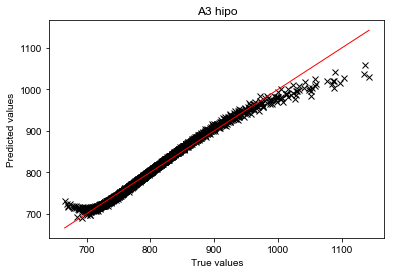

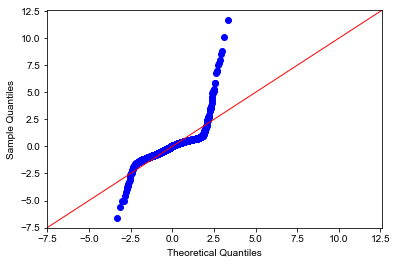

In [81]:
# Hipoeutectoid
filtered_dataset = dataset[dataset.eutectoid == 'hipo']
reg['hipo'], results['hipo'] = regression_poly_2nd_deg(
    dataset=filtered_dataset,
    dep_var=dep_var, maxpvalue=.01,
    printsummary=False)

ax = plot_fitting_results(results['hipo'], filtered_dataset, dep_var)
ax.set_title('{} hipo'.format(dep_var))

residuals = results['hipo'].resid # residuals
pplot = sm.ProbPlot(residuals, fit=True)
pplot.qqplot(line='45')

print(results['hipo'].summary())

3 iteration(s)
                            OLS Regression Results                            
Dep. Variable:                     A3   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.318e+05
Date:                Fri, 14 Sep 2018   Prob (F-statistic):               0.00
Time:                        04:20:15   Log-Likelihood:                -11824.
No. Observations:                4542   AIC:                         2.368e+04
Df Residuals:                    4524   BIC:                         2.380e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    440.5324      0.819    5

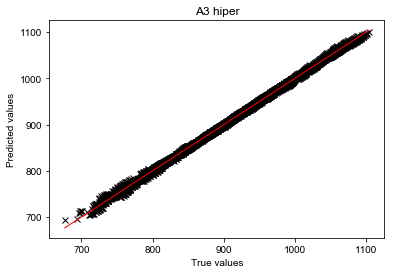

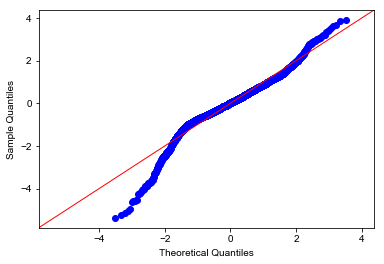

In [82]:
# Hipereutectoid
filtered_dataset = dataset[dataset.eutectoid == 'hiper']
reg['hiper'], results['hiper'] = regression_poly_2nd_deg(
    dataset=filtered_dataset,
    dep_var=dep_var, maxpvalue=.01,
    printsummary=False)

ax = plot_fitting_results(results['hiper'], filtered_dataset, dep_var)
ax.set_title('{} hiper'.format(dep_var))

residuals = results['hiper'].resid # residuals
pplot = sm.ProbPlot(residuals, fit=True)
pplot.qqplot(line='45')

print(results['hiper'].summary())

    fjac: array([[-1.]])
     fun: array([  6.93489710e-12])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([  1.37096765e-06])
       r: array([ 488.0000775])
  status: 1
 success: True
       x: array([ 0.7177963])
    fjac: array([[-1.]])
     fun: array([  1.35287337e-11])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([  2.23060454e-06])
       r: array([ 535.77046998])
  status: 1
 success: True
       x: array([ 0.7124967])
    fjac: array([[-1.]])
     fun: array([  7.95807864e-13])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([  3.56646069e-07])
       r: array([ 575.63548799])
  status: 1
 success: True
       x: array([ 0.72270576])
    fjac: array([[-1.]])
     fun: array([  1.13686838e-13])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([  4.03588274e-11])
       r: array([ 609.14562452])
  status: 1
 success: True
       x: array([ 0.7453749])
    fjac: array([[-1.]])
     fun: array([  2.27373675e-13])

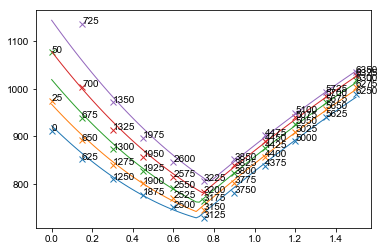

In [83]:
def A3(C=0, Mn=0, Si=0, Cr=0, Ni=0):
    """
    A3 temperature for either hipo or hipereutectoid alloy
    """
    def Thipo(C):
        df = pd.DataFrame(dict(C=C, Mn=Mn, Si=Si, Cr=Cr, Ni=Ni))
        return results['hipo'].predict(df)

    def Thiper(C):
        df = pd.DataFrame(dict(C=C, Mn=Mn, Si=Si, Cr=Cr, Ni=Ni))
        return results['hiper'].predict(df)

    Ceut = root(fun=lambda x: Thipo(x) - Thiper(x), x0=.75)
    print(Ceut)
    Ceut = Ceut.x[0]

    T = np.ndarray(C.shape)
    T[C <= Ceut] = Thipo(C[C <= Ceut])
    T[C > Ceut] = Thiper(C[C > Ceut])

    return T

# plot isopleths
fig, ax = plt.subplots()

# compositions (level)
Mn = 0
Si = 0
Cr = 0
Ni = 0

# compositions (wt.%)
C_ = 100*np.linspace(crange['C'].min, crange['C'].max, 100)

for Si in range(5):
    # compositions (wt.%)
    Mn_ = 100*crange['Mn'].array[Mn]
    Si_ = 100*crange['Si'].array[Si]
    Cr_ = 100*crange['Cr'].array[Cr]
    Ni_ = 100*crange['Ni'].array[Ni]

    # experimental isopleth
    isopleth = select_carbon_isopleth(dataset_multi, Mn, Si, Cr, Ni)

    line, = plot_carbon_isopleth(isopleth, dep_var, ax,
                                 ls='none', marker='x',
                                 annotate=True)

    # predicted isopleth
    if dep_var == 'A3':
        ax.plot(C_, A3(C_, Mn_, Si_, Cr_, Ni_), color=line.get_color())

    else:
        criteria = isopleth['eutectoid'] == 'hipo'
        ax.plot(isopleth['C'][criteria],
                results['hipo'].predict(isopleth)[criteria],
                color=line.get_color())

        criteria = isopleth['eutectoid'] == 'hiper'
        ax.plot(isopleth['C'][criteria],
                results['hiper'].predict(isopleth)[criteria],
                color=line.get_color())

plt.show()

In [88]:
# concatenate fitting params of results['hipo'] and results['hiper'] 
# into a single DataFrame
coef_ = dict(hipo=results['hipo'].params, hiper=results['hiper'].params)
coef = pd.concat(coef_, axis=1, sort=False)
# fill the NaN with zeros
coef.fillna(0, inplace=True)
coef

,hiper,hipo
Intercept,440.532422,922.199022
C,435.484394,-418.550484
I(C ** 2),-49.545444,205.418751
I(C * Mn),0.556977,53.263717
I(C * Si),0.460087,-59.633579
I(C * Cr),-27.767850,16.756056
I(C * Ni),-0.768428,38.519142
I(Mn * Si),0.682520,-8.544235
I(Mn * Cr),0.101839,1.975529
I(Mn * Ni),-0.278403,5.151572


In [114]:
alpha = .5*(coef['hipo'] - coef['hiper'])/(coef['hipo']['I(C ** 2)'] - coef['hiper']['I(C ** 2)'])
# print(alpha)

def Ceut(Mn=0, Si=0, Cr=0, Ni=0):
    b = alpha['C'] + alpha['I(C * Mn)']*Mn + alpha['I(C * Si)']*Si + \
        alpha['I(C * Cr)']*Cr + alpha['I(C * Ni)']*Ni
    c = alpha['Intercept'] + \
        alpha['Mn']*Mn + alpha['Si']*Si + alpha['Cr']*Cr + alpha['Ni']*Ni + \
        alpha['I(Mn ** 2)']*Mn**2 + alpha['I(Mn * Si)']*Mn*Si + alpha['I(Mn * Cr)']*Mn*Cr + alpha['I(Mn * Ni)']*Mn*Ni + \
        alpha['I(Si ** 2)']*Si**2 + alpha['I(Si * Cr)']*Si*Cr + alpha['I(Si * Ni)']*Si*Ni + \
        alpha['I(Cr ** 2)']*Cr**2 + alpha['I(Cr * Ni)']*Cr*Ni + \
        alpha['I(Ni ** 2)']*Ni**2
    return -b - (b**2. - 2.*c)**.5

Ceut()

0.71781498128335597